In [1]:
# ========= 1) Setup =========
# Install required libraries if needed
# !pip install medmnist torch torchvision shap matplotlib

import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import shap
import numpy as np
import random
import os

import medmnist
from medmnist import INFO

/Users/melissa/Desktop/UVG/2025/RIA/Lab03-CC3106/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ========= 2) Dataset Info =========
data_flag = 'pathmnist'
download = True

info = INFO[data_flag]
n_classes = len(info['label'])
id2label = {int(k): v for k, v in info['label'].items()}

print(f"Dataset: {info['description']}")
print(f"Task: {info['task']}, Classes: {n_classes}")
print("Classes:", id2label)

Dataset: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.
Task: multi-class, Classes: 9
Classes: {0: 'adipose', 1: 'background', 2: 'debris', 3: 'lymphocytes', 4: 'mucus', 5: 'smooth muscle', 6: 'normal colon mucosa', 7: 'cancer-associated stroma', 8: 'colorectal adenocarcinoma epithelium'}


/var/folders/1_/typt0bhn7_q_v0p0c8csdvmh0000gn/T/ipykernel_8565/3842754038.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axs[i].set_title(f"{id2label[int(label)]}")  # ✅ cast label to int
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6313726..0.84313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.372549..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.32549018..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44313723..0.90588236].


Train size: 89996  Test size: 7180


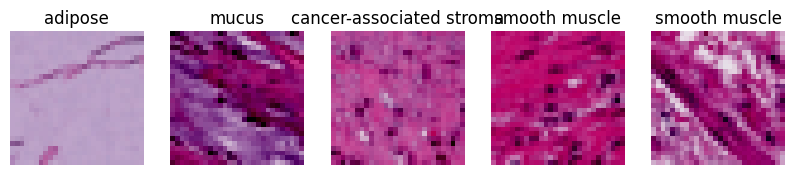

In [3]:
# ========= 3) Load dataset =========
DataClass = getattr(medmnist, info['python_class'])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = DataClass(split='train', transform=transform, download=download)
test_dataset  = DataClass(split='test', transform=transform, download=download)

print("Train size:", len(train_dataset), " Test size:", len(test_dataset))

# Show 5 sample images
fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    img, label = train_dataset[i]
    img = img.numpy()
    axs[i].imshow(np.transpose(img, (1, 2, 0)).squeeze(), cmap="gray")
    axs[i].set_title(f"{id2label[int(label)]}")  # ✅ cast label to int
    axs[i].axis("off")
plt.show()

In [4]:
# ========= 4) Define Simple CNN Model (already provided) =========
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*14*14, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        return x

model = SimpleCNN(info['n_channels'], n_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model class defined and ready.")

Model class defined and ready.


In [5]:
# ========= 5) Load Pretrained Model =========
MODEL_PATH = "../pathmnist_simplecnn.pth"

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

print("Pretrained model loaded successfully!")

Pretrained model loaded successfully!


/var/folders/1_/typt0bhn7_q_v0p0c8csdvmh0000gn/T/ipykernel_8565/2213035316.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_class_name = id2label[int(sample_label)]


[Single Image] Index 6596
Predicted: smooth muscle (p=0.710)
True:      smooth muscle


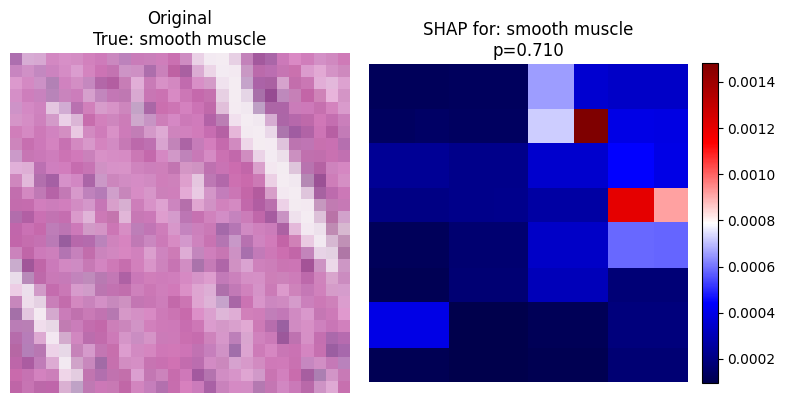

In [6]:
# ========= 6) Predictions + SHAP Explanations =========
# In this cell, you will:
#   1. Write a helper function so SHAP can call the model
#   2. Pick one test image and predict its class
#   3. Compare prediction vs. true label
#   4. Use SHAP to explain WHY the model made that prediction
#   5. Visualize the results

# --- Step 1: Helper function for SHAP ---
# TODO: Implement model_forward(x)
# HINT: x will come as a numpy array with shape (N, H, W, C).
#       Convert it to a torch tensor (N, C, H, W), run through the model,
#       return probabilities as numpy.
def model_forward(x):
    # Convert numpy (N, H, W, C) -> torch (N, C, H, W), move to device, run model
    model.eval()
    with torch.no_grad():
        if isinstance(x, np.ndarray):
            x_t = torch.from_numpy(x.astype(np.float32))
        else:
            x_t = x.float()
        if x_t.ndim == 3:
            # (H, W, C) -> add batch
            x_t = x_t.unsqueeze(0)
        # (N, H, W, C) -> (N, C, H, W)
        x_t = x_t.permute(0, 3, 1, 2).to(device)
        logits = model(x_t)
        probs = F.softmax(logits, dim=1)
        return probs.detach().cpu().numpy()


# --- Step 2: Pick one test image ---
# TODO: Select an image from test_dataset
# HINT: take sample_img, sample_label = test_dataset[0] (or a random index)
# TODO: Predict class probabilities using the model
# TODO: Print predicted class (with probability) and true label
# (use id2label to show class names)

# Pick a random test sample for demonstration
random_idx = random.randint(0, len(test_dataset) - 1)
sample_img_t, sample_label = test_dataset[random_idx]   # sample_img_t is (C, H, W) torch tensor (already normalized)
true_class_name = id2label[int(sample_label)]

# --- Step 3: Prepare image for SHAP ---
# TODO: Convert the image into numpy format (H, W, C)
# HINT: remember test_dataset gives (C, H, W), so you might need np.transpose
img_np = np.transpose(sample_img_t.numpy(), (1, 2, 0))  # (H, W, C) normalized image in [-1, 1] range due to Normalize(.5,.5)

# Predict using the helper (probabilities)
probs = model_forward(img_np[np.newaxis, ...])[0]  # (n_classes,)
pred_idx = int(np.argmax(probs))
pred_prob = float(probs[pred_idx])
pred_class_name = id2label[pred_idx]

print(f"[Single Image] Index {random_idx}")
print(f"Predicted: {pred_class_name} (p={pred_prob:.3f})")
print(f"True:      {true_class_name}")

# --- Step 4: Create SHAP explainer ---
# TODO: Create a masker for images
# HINT: shap.maskers.Image("blur(28,28)", img_np.shape)
# TODO: Create an Explainer with (model_forward, masker)
# TODO: Run explainer on your selected image
masker = shap.maskers.Image("blur(28,28)", img_np.shape)
explainer = shap.Explainer(model_forward, masker)

shap_exp = explainer(img_np[np.newaxis, ...])  # returns a shap Explanation object

# --- Step 5: Visualize ---
# TODO: Plot the original image and the SHAP heatmap side by side
# HINT: use matplotlib subplots

# For display, denormalize to [0,1] for nicer visualization
disp_img = np.clip((img_np * 0.5) + 0.5, 0.0, 1.0)

# SHAP values typically come as (N, H, W, C, n_classes) for image tasks with probability outputs
# We'll extract the attribution map for the predicted class
if hasattr(shap_exp, "values") and shap_exp.values is not None:
    # Newer SHAP returns .values shaped like above; handle both older/newer shapes defensively
    vals = shap_exp.values
    if vals.ndim == 5:
        heatmap = vals[0, :, :, :, pred_idx].mean(axis=2)  # average over channels for a 2D map
    elif vals.ndim == 4:
        # Sometimes shape can be (N, H, W, C); if so, average channels
        heatmap = vals[0].mean(axis=2)
    else:
        # Fallback: try squeezing and averaging last axis if present
        heatmap = np.squeeze(vals[0])
        if heatmap.ndim == 3:
            heatmap = heatmap.mean(axis=2)
else:
    # If the object uses .values-like access via .__array__()
    vals = np.array(shap_exp)
    if vals.ndim == 5:
        heatmap = vals[0, :, :, :, pred_idx].mean(axis=2)
    elif vals.ndim == 4:
        heatmap = vals[0].mean(axis=2)
    else:
        heatmap = np.squeeze(vals[0])
        if heatmap.ndim == 3:
            heatmap = heatmap.mean(axis=2)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(disp_img.squeeze())
axs[0].set_title(f"Original\nTrue: {true_class_name}")
axs[0].axis("off")

im = axs[1].imshow(heatmap, cmap="seismic")
axs[1].set_title(f"SHAP for: {pred_class_name}\np={pred_prob:.3f}")
axs[1].axis("off")
plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

/var/folders/1_/typt0bhn7_q_v0p0c8csdvmh0000gn/T/ipykernel_8565/2478352907.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lbl_name = id2label[int(lbl)]
/var/folders/1_/typt0bhn7_q_v0p0c8csdvmh0000gn/T/ipykernel_8565/2478352907.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  correct = "✓" if p_idx == int(lbl) else "✗"
/var/folders/1_/typt0bhn7_q_v0p0c8csdvmh0000gn/T/ipykernel_8565/2478352907.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


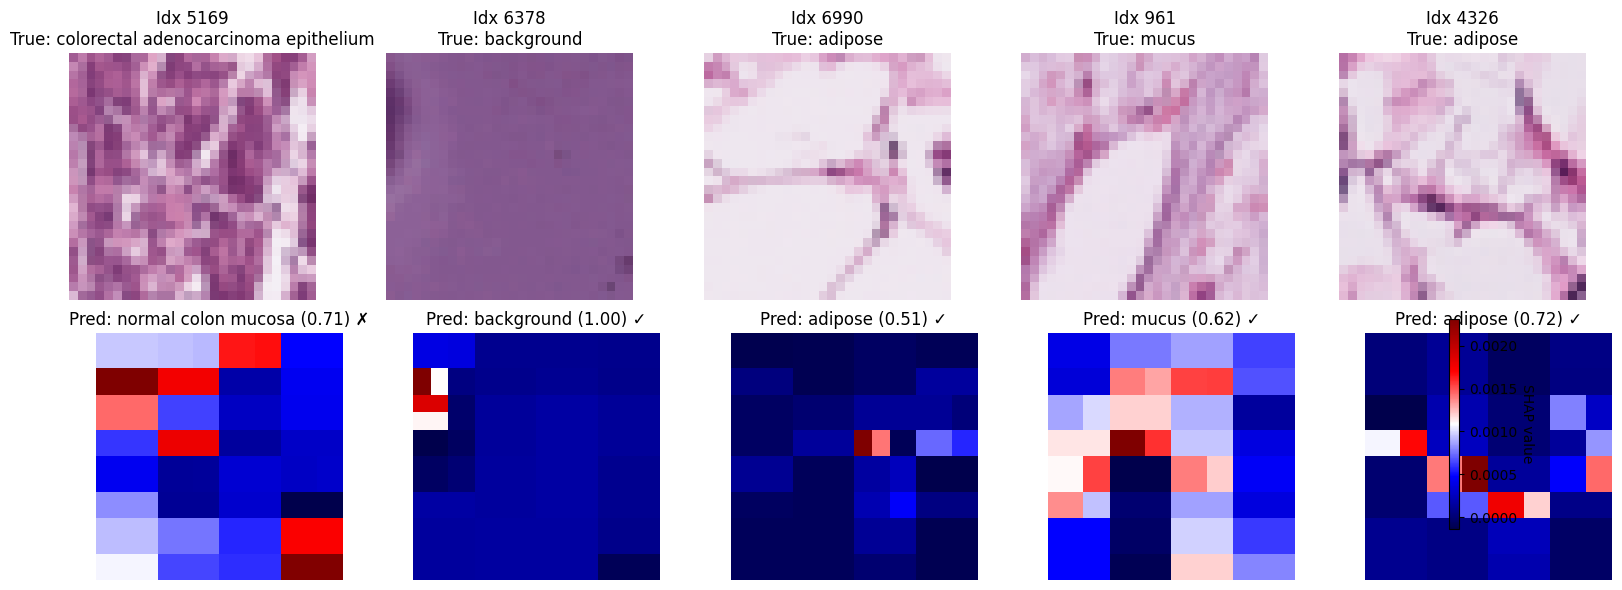

In [7]:
# ========= 7) Extension: Multiple Images =========
# TODO: Loop over 5 random test images
# For each:
#   - Show original image with true label
#   - Predict with the model and show predicted label + probability
#   - Plot SHAP heatmap for predicted class
# HINT: Use matplotlib with 2 rows and 5 columns

# We'll reuse the same explainer for efficiency
num_samples = 5
indices = random.sample(range(len(test_dataset)), num_samples)

fig, axs = plt.subplots(2, num_samples, figsize=(3.2 * num_samples, 6))

for col, idx in enumerate(indices):
    img_t, lbl = test_dataset[idx]  # (C,H,W), normalized
    lbl_name = id2label[int(lbl)]

    img_np = np.transpose(img_t.numpy(), (1, 2, 0))           # (H,W,C)
    disp_img = np.clip((img_np * 0.5) + 0.5, 0.0, 1.0)        # denormalize for display

    # Predict
    probs = model_forward(img_np[np.newaxis, ...])[0]
    p_idx = int(np.argmax(probs))
    p_prob = float(probs[p_idx])
    p_name = id2label[p_idx]

    # Explain
    exp = explainer(img_np[np.newaxis, ...])

    # Extract heatmap for predicted class (robust to shape variants)
    if hasattr(exp, "values") and exp.values is not None:
        vals = exp.values
    else:
        vals = np.array(exp)

    if vals.ndim == 5:
        heatmap = vals[0, :, :, :, p_idx].mean(axis=2)
    elif vals.ndim == 4:
        heatmap = vals[0].mean(axis=2)
    else:
        heatmap = np.squeeze(vals[0])
        if heatmap.ndim == 3:
            heatmap = heatmap.mean(axis=2)

    # Row 1: original image
    ax0 = axs[0, col] if num_samples > 1 else axs[0]
    ax0.imshow(disp_img.squeeze())
    ax0.set_title(f"Idx {idx}\nTrue: {lbl_name}")
    ax0.axis("off")

    # Row 2: SHAP heatmap for predicted class
    ax1 = axs[1, col] if num_samples > 1 else axs[1]
    im = ax1.imshow(heatmap, cmap="seismic")
    correct = "✓" if p_idx == int(lbl) else "✗"
    ax1.set_title(f"Pred: {p_name} ({p_prob:.2f}) {correct}")
    ax1.axis("off")

# Add a single colorbar for the bottom row
cbar = fig.colorbar(im, ax=axs[1, :], fraction=0.015, pad=0.04)
cbar.ax.set_ylabel("SHAP value", rotation=270, labelpad=12)
plt.tight_layout()
plt.show()

In [8]:
# ========= 8) Reflection =========
# Answer in text (Markdown or comments):
# 1. Why did the model predict this class?
# 2. Are the SHAP heatmaps focusing on meaningful regions?
# 3. What differences do you see between correct and incorrect predictions?
# 4. How could interpretability help improve this model?